# **I. Data**

In [11]:
data_path = "/Linux/Odor/DAT/"
output_path = "/Linux/Odor/OUT/"

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import r2_score
import seaborn as sns

### 직접 생성한 패키지
from My_code.Odor_Analysis import Odor
from My_code.Metrics import R2, MAE

In [13]:
### 원 데이터
odor = pd.read_csv(data_path + "New_data2.csv", encoding="euc-kr")
odor = odor.drop(["yy", "mm", "dd", "farm"], axis = 1)    # 불필요한 변수 제거
odor.rename(columns = {"mm.1" : "mm"}, inplace = True)    # 추후 변수명을 편하게 사용하기 위해
print(odor.shape)
display(odor.head())

(57, 16)


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,NaN,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,NaN,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,NaN,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92
3,2080,1.02,344.0,NaN,13.0,0.63,490.79,570.61,51.09,719.27,168.48,237.64,8.90,60.56,5.55,7.31
4,310,1.18,312.0,NaN,NaN,NaN,404.53,468.03,43.17,573.75,157.22,205.67,9.21,69.90,NaN,5.43


In [14]:
### 결측값 확인
num_na = odor.isna().sum().sum()


print("NA 개수 :", num_na) #, " ND 개수 :",  num_nd)
na = pd.DataFrame(odor.isna().sum(), columns = ["NA"]).transpose()
na_per = np.round(na/odor.shape[0], 3)
na_per.index = ["NA (%)"]

na_df = pd.concat([na, na_per], axis = 0)
na_df

NA 개수 : 155


,ou,nh3,h2s,mm,dms,dmds,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
NA,0.0,0.0,0.0,31.000,36.000,52.000,0.0,1.000,1.000,1.000,0.0,1.000,2.000,1.000,21.000,8.00
NA (%),0.0,0.0,0.0,0.544,0.632,0.912,0.0,0.018,0.018,0.018,0.0,0.018,0.035,0.018,0.368,0.14


In [15]:
odor2 = odor.drop(columns = ["dmds"])
print(odor2.shape)
odor2.head(3)

(57, 15)


,ou,nh3,h2s,mm,dms,aca,ppa,iba,bta,iva,vla,ph,pc,id,sk
0,300,0.56,145.0,NaN,12.8,30.60,17.57,2.78,10.80,3.64,7.72,2.84,NaN,NaN,3.00
1,300,0.62,310.0,19.4,462.0,916.52,1055.96,109.07,977.44,319.49,619.49,30.51,137.81,3.60,10.40
2,448,0.97,90.5,NaN,63.9,663.42,737.23,73.94,837.83,215.64,469.79,14.61,67.52,0.94,3.92


# **Result**

- 나눠서 하는것이 좋음

In [77]:
# 33
seed = 77

In [78]:
result = Odor(data = odor2, missing = "Multivariate(BayesianRidge) Imp", Variable = "None", Model = "Extra Tree", SEED = seed)
pred = result["prediction"]
pred_df1 = pd.DataFrame(pred, columns = ['rank 1'])

In [79]:
result = Odor(data = odor2, missing = "KNN Imp", Variable = "PCA", Model = "XGboost", SEED = seed)
pred = result["prediction"]
pred_df2 = pd.DataFrame(pred, columns = ['rank 2'])

In [80]:
result = Odor(data = odor2, missing = "KNN Imp", Variable = "PCA", Model = "Random Forest", SEED = seed)
pred = result["prediction"]
pred_df3 = pd.DataFrame(pred, columns = ['rank 3'])

In [81]:
result = Odor(data = odor2, missing = "KNN Imp", Variable = "None", Model = "Extra Tree", SEED = seed)
pred = result["prediction"]
pred_df4 = pd.DataFrame(pred, columns = ['rank 4'])

In [82]:
result = Odor(data = odor2, missing = "Multivariate(ExtraTree) Imp", Variable = "None", Model = "Extra Tree", SEED = seed)
pred = result["prediction"]
pred_df5 = pd.DataFrame(pred, columns = ['rank 5'])

/opt/conda/lib/python3.7/site-packages/sklearn/impute/_iterative.py:686: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [83]:
pred_df = pd.concat([pred_df1, pred_df2, pred_df3, pred_df4, pred_df5], axis = 1)
# pred_df.head()

,rank 1,rank 2,rank 3,rank 4,rank 5
0,743.60,522.700989,552.17,510.06,515.92
1,1072.21,1089.156982,1333.14,1282.42,1444.78
2,742.01,1700.037964,1881.46,1311.32,932.85
3,1880.10,608.961975,746.98,1454.34,1751.72
4,543.68,686.508972,739.18,484.34,552.06


In [84]:
actual = odor2.loc[:,"ou"]
r2_ols_list = []
mae_list = []

for i in range(pred_df.shape[1]) :
    const_pred_list = sm.add_constant(pred_df.iloc[:, i], has_constant = "add")
    ols = sm.OLS(actual, const_pred_list).fit()
    r2_ols_list.append(np.round(ols.rsquared, 3))
    mae_list.append(MAE(actual, pred_df.iloc[:, i]))

In [85]:
result_df = pd.DataFrame([r2_ols_list, mae_list]).T  # R2 : 0.342
# result_df

,0,1
0,0.376,729.064
1,0.283,849.316
2,0.281,822.884
3,0.238,811.275
4,0.267,783.740


In [94]:
result_mean = pd.DataFrame(pred_df.mean(axis = 1), columns = ["mean"])
pred_df2 = pd.concat([pred_df, result_mean], axis = 1)
pred_df2 = pred_df2.drop(['rank 4', 'rank 5'], axis = 1)
# pred_df2.head()

,rank 1,rank 2,rank 3,mean
0,743.60,522.700989,552.17,568.890198
1,1072.21,1089.156982,1333.14,1244.341396
2,742.01,1700.037964,1881.46,1313.535593
3,1880.10,608.961975,746.98,1288.420395
4,543.68,686.508972,739.18,601.153794


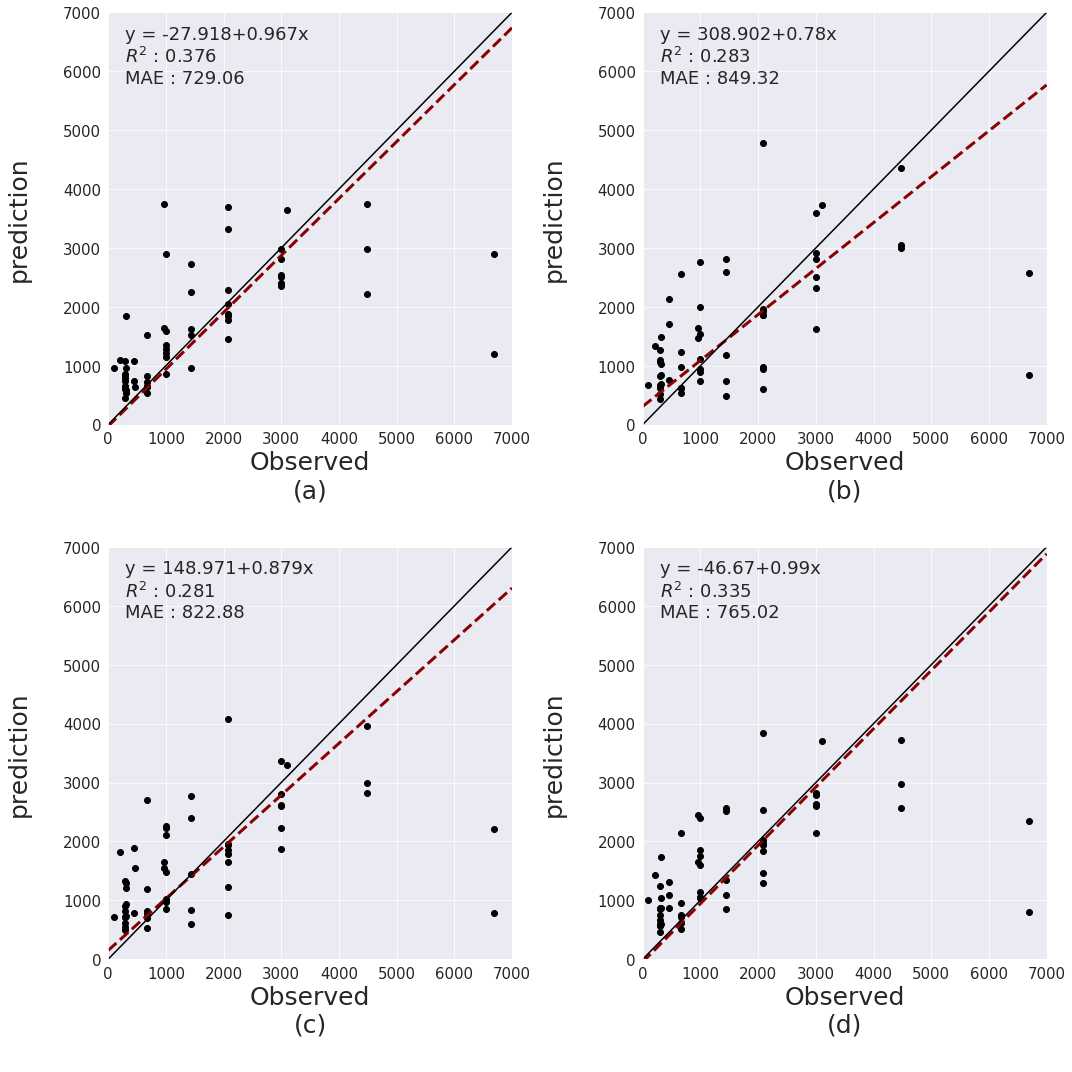

In [93]:
sns.set_style('darkgrid')
plt.figure(figsize = (15, 15))

alphabet = ["a", "b", "c", "d"]

for i in range(pred_df2.shape[1]) :
    const_pred_list = sm.add_constant(pred_df2.iloc[:, i], has_constant = "add")
    pred_ols = sm.OLS(actual, const_pred_list).fit()
    linear_x = range(0, 8000, 1000)
    linear_y = pred_ols.params[0] + pred_ols.params[1]*linear_x
    
    plt.subplot(2, 2, i+1)
    plt.scatter(actual, pred_df2.iloc[:, i], color = "black")
    plt.xlim(0, 7000) ; plt.ylim(0, 7000)
    plt.plot(linear_x, linear_y, color = "darkred", linestyle = "--", linewidth = 3)
    plt.plot([0, 7000], [0, 7000], color = "black")
    plt.xlabel("Observed\n({})\n".format(alphabet[i]), fontsize = 25)  ; plt.ylabel("prediction\n", fontsize = 25)
    plt.xticks(fontsize = 15)  ; plt.yticks(fontsize = 15)

    plt.text(300, 5800,
             "y = " + str(np.round(pred_ols.params[0], 3)) + "+" + str(np.round(pred_ols.params[1], 3)) + "x" +
             "\n$R^2$" + " : " + str(np.round(pred_ols.rsquared, 3)) + 
             "\nMAE : " + str(np.round(MAE(actual, pred_df2.iloc[:, i]), 2)),
             fontsize = 18,
             bbox = dict(facecolor = "white", edgecolor = 'none', boxstyle = 'round', alpha = 0))

plt.tight_layout()
plt.show()